<div align='center' ><font size='35'> B505 Assignment-6 solution </font></div>

<div align='center' >Yu Mo (moyu@iu.edu) </font></div>
<div align='center' >work with Ritwik Budhiraja (rbudhira@iu.edu) </font></div>

# Expectation-Maximization Algorithm
##  initialization
*  Suppose there are k clusters of which which the prior is $N(\mu， I_d)$, where $\mu$ is a d-dimension vector chosen from data randomly, $I_d$ is d-dimension identity matrix. For each cluster, the prior weight is $\frac{1}{k}$.
* Given prior, calculate the posterior probability for each cluster. Then, update the mean, covriance matrix, prior for each cluster. Keep iterating until the algorithm converge.
* The stop criteria is  
<div align='center' > $\sum_{i=1,..,k} ||\mu_i^{t-1}-\mu_i^{t}||^2<\epsilon$ </font></div>
where $\epsilon = 10^{-3}$

In [13]:
import csv, matplotlib
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal
from copy import deepcopy
#%% parse data
def parse_from_file(fileloc):
    with open(fileloc) as csvfile:
        csf = list(csv.reader(csvfile))
    return np.array([[float(y) for y in x[:-1]] for x in csf]), [x[-1] for x in csf]

In [ ]:
def expecti_max(data,k,eps):
    t = 0
    n, d = np.shape(data)
    mu = np.zeros([k,d])
    prob_c = [0] * k
    co_var = [0] * k
    post_prob = [[0 for j in range(n)] for i in range(k)]
    
    #random.seed(1)
    # initialize Gaussian
    for i in range(k):
        mu[i,:] = data[np.random.randint(0, n-1),:]
        co_var[i] = np.identity(d)
        prob_c[i] = 1 / k
    
    prev_mu = deepcopy(mu)
    
    while True:
        t += 1
        # E-Step  
        for i in range(k):
            for j in range(n):
                all_post_prob = [calc_post_pro(data[j], mu[a], co_var[a], prob_c[a]) for a in range(k)]
                post_prob[i][j] = all_post_prob[i]/sum(all_post_prob)
                    
        # M-Step
        for i in range(k):
            sum_post = sum(post_prob[i])
            mu[i] = co_var[i] = 0
            for j in range(n):
                mu[i] += post_prob[i][j] * data[j] /sum_post
                co_var[i] += post_prob[i][j]*np.outer(data[j]-mu[i],data[j]-mu[i])/sum_post
            prob_c[i] = sum_post/n
            
        # check convergence
        converge_val = sum( [sum((i-j)**2) for i,j in zip(mu,prev_mu)] )
        if converge_val <= eps:
            return mu, co_var, prob_c, post_prob,  t
        else:
             prev_mu = deepcopy(mu)

def calc_post_pro(d, mu, co_var, prob_c): 
    post_prob = multivariate_normal.pdf(d, mu, co_var, allow_singular=True)*prob_c
    return post_prob


## evaluation
* Suppose there are 2 clusters to predict.Compare the center of predicted clusters and center of actual clusters. Then calculate the proportion of correct prediction. The error rate is $1-accuracy$. 
* If there are k ($k>2$) clusters to predict, map each cluster to acutal cluster based on the shortest Euclidean distance. Then k-cluster case is back to two-cluster case. Calcuate error rate as preivous step.

In [ ]:
def cal_error(data, label, post_prob, g_center, b_center, label_name):
    n = len(data)
    k = len(post_prob)
    lb0, lb1 = label_name
    post_prob = np.array(post_prob).T
    # partition the data points to k-clusters
    predict_label = [np.argmax(row) for row in post_prob]
    # two clusters
    if k == 2:
        c0_index = [x == 0 for x in predict_label] 
        c0_center = np.mean(data[c0_index], 0)
        dist_c0_g = sum( (c0_center-g_center)**2 )
        dist_c0_b = sum( (c0_center-b_center)**2 )
        # if the center of c0 is closer to "good"
        if dist_c0_g < dist_c0_b: 
            predict_label = [lb0 if x == 0 else lb1 for x in predict_label  ]
        else:
            predict_label = [lb1 if x == 0 else lb0 for x in predict_label  ]
    else:
        for i in range(k):
            ci_index = [x == i for x in predict_label]
            ci_center= np.mean(data[ci_index], 0)
            # map ci into (g-lb0) or (b-lb1)
            dist_ci_g = sum( (ci_center-g_center)**2 )
            dist_ci_b = sum( (ci_center-b_center)**2 )
            if dist_ci_g < dist_ci_b:
                predict_label = [lb0 if x == i else x for x in predict_label ]
            else:
                predict_label = [lb1 if x == i else x for x in predict_label ]

    # number of correct prediction in each predicted cluster
    p_g_count = sum([1 for x,y in zip(label, predict_label) if x == y and y == lb0])
    p_b_count = sum([1 for x,y in zip(label, predict_label) if x == y and y == lb1])
    error = 1 - (p_g_count+p_b_count)/n
    return error

In [ ]:
def find_cluster_true_center(data, label, label_name):
    lb0, lb1 = label_name
    g_ind = [True if x == lb0 else False for x in label]
    b_ind = [True if x == lb1 else False for x in label]
    c0 = data[g_ind]
    c1 = data[b_ind]
    return np.mean(c0, 0), np.mean(c1, 0)

In [14]:
def main(data, label):
    # rescale for ringnorm
    label_name = list( set(label) )
    g_center, b_center = find_cluster_true_center(data, label, label_name)
    tot_error = [[]]
    tot_ite = [[]]
    for k_clst in range(2,6):
        error = []
        iteration = []
        for nrun in range(20):
            mu, co_var, prob_c, post_prob, ite = expecti_max( data, k_clst, eps=1e-3)
            err = cal_error(data, label, post_prob, g_center, b_center, label_name)
            error.append(err)
            iteration.append(ite)
        print('error in %s-cluster case is %.4f' %(k_clst, np.mean(error)) )
        tot_ite.append(iteration)
        tot_error.append(error)

    # whisker plot
    medianprops = dict(linestyle='-.', linewidth=2, color='black')
    matplotlib.rcParams.update({'font.size': 12})
    plt.figure(dpi=100)
    plt.hold = True
    plt.boxplot(tot_ite,vert=0, sym = 'o', patch_artist = True, medianprops=medianprops)
    plt.xlabel('Iteration counts')
    plt.ylabel('Number of clusters (k)')
    plt.show()

    plt.figure(dpi=100)
    plt.hold = True
    plt.boxplot(tot_error,vert=0, sym = 'o',patch_artist = True, boxprops = {'facecolor':'green'},  medianprops=medianprops)
    plt.xlabel('Average error rate for 20 runs')
    plt.ylabel('Number of clusters (k)')
    plt.show()

# Analysis of the EM over Real-world Data Sets

* There are 34 attributes and 2 labels in dataset $\textit ionosphere$. Run 20 times for k-cluster case, which starts from different $\mu$ of prior. Record number of iterations and the error rateand. Plot them as a function of k.  
* The number of iteration is around $10$ for each k. 
* The error is around $0.25$ for each k. 

error in 2-cluster case is 0.2660
error in 3-cluster case is 0.2510
error in 4-cluster case is 0.2556
error in 5-cluster case is 0.2540


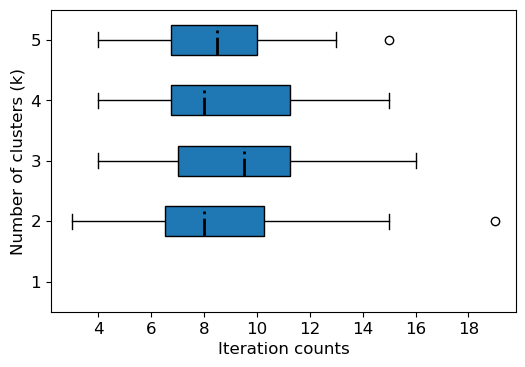

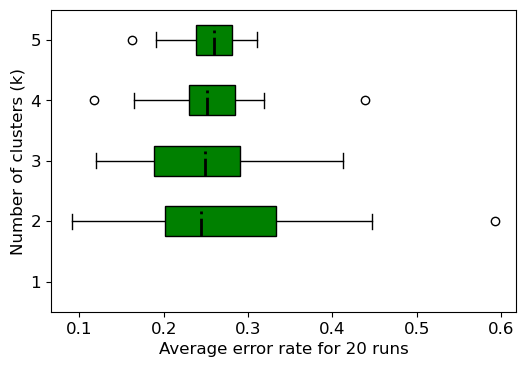

In [15]:
fileloc = r'ionosphere.data'
data, label = parse_from_file(fileloc)
main( data, label )

* There are 20 attributes and 2 labels in dataset $\textit ringnorm$. Run 20 times for k-cluster case, which starts from different $\mu$ of prior. Record number of iterations and the error rateand. Plot them as a function of k. 
* A Z-score transformation is implement. Calculate the sample mean and sample variance. Then,
<div align='center' > $x_i^{\prime} = \frac{x_i-\mu_s}{\sigma}$ </font></div>
input $x_i^{\prime}$ for update. The reason for transformation is to avoid extremely low probability due to the magnitude of data.
* The number of iteration varies for k-cluster case. More iterations are required as $k$ increases.
* The error is around $0.02$ for each k. 

error in 2-cluster case is 0.0230
error in 3-cluster case is 0.0222
error in 4-cluster case is 0.0223
error in 5-cluster case is 0.0227


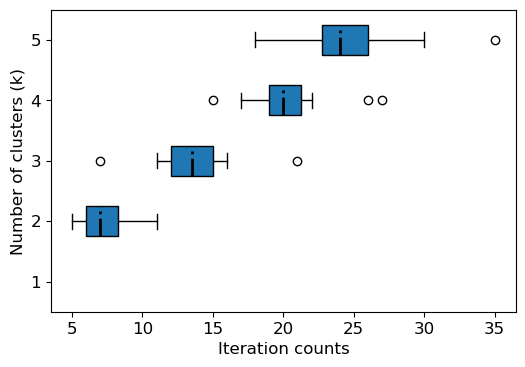

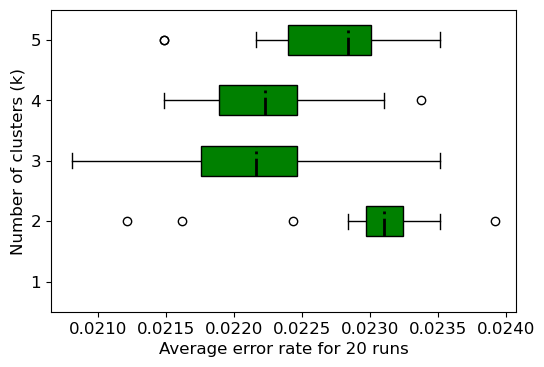

In [16]:
fileloc = r'ringnorm.data'
data, label = parse_from_file(fileloc)

# z-score
mean_data = np.mean(data, 0)
std_data = np.std(data, 0)
data_normalized = (data-mean_data)/std_data
main( data_normalized, label )

# Algorithm Design

## 

In [ ]:
def binarySearch (arr, l, r, x):
    if r >= l:
        mid = l + (r - l) // 2
        if arr[mid] == x:
            return 1
        elif arr[mid] > x:
            return binarySearch(arr, l, mid-1, x)
        else:
            return binarySearch(arr, mid + 1, r, x)
    else:
        return 0

## 

In [ ]:
def merge(arr, l, m, r):
    n1 = m - l + 1
    n2 = r - m


    L = [0] * (n1)
    R = [0] * (n2)


    for i in range(0, n1):
        L[i] = arr[l + i]

    for j in range(0, n2):
        R[j] = arr[m + 1 + j]

    i = 0
    j = 0
    k = l

    while i < n1 and j < n2:
        if L[i] <= R[j]:
            arr[k] = L[i]
            i += 1
        else:
            arr[k] = R[j]
            j += 1
        k += 1


    while i < n1:
        arr[k] = L[i]
        i += 1
        k += 1

    while j < n2:
        arr[k] = R[j]
        j += 1
        k += 1

## 

In [ ]:
def mergeSort(arr, l, r):
    if l < r:

        m = l+(r-l)//2

        mergeSort(arr, l, m)
        mergeSort(arr, m+1, r)
        merge(arr, l, m, r)

def find_sum(x,y,z,t):
    m = len(x)
    xy_list = []
    for ele_x in x:
        for ele_y in y:
            xy_list.append(ele_x + ele_y)
    mergeSort(z,0,m-1)
    for ele_xy in xy_list:
        if binarySearch(z,0,m - 1,t - ele_xy):
            return 1
        else:
            continue
    return 0